# Re-cash 주식채권현금 분산투자전략

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
from Library import FinanceLibrary as fl

In [2]:
import os
print (os.getcwd())

C:\DualMomentum\BackTesting


In [3]:
df_kodex = pd.read_csv("..\\Data\\KODEX200_daily_data.csv", encoding="utf-8")
df_bond10 = pd.read_csv("..\\Data\\KOSEF국고채10년_daily_data.csv", encoding="utf-8")
df_bond3 = pd.read_csv("..\\Data\\KODEX국고채3년_Daily_2010data.csv", encoding="utf-8")

In [4]:
df_kodex.index = pd.to_datetime(df_kodex["Date"])
df_bond10.index = pd.to_datetime(df_bond10["Date"])
df_bond3.index = pd.to_datetime(df_bond3["Date"])

# 시작하는 날짜 지정하기, 채권 시작하는 날이 2011-12월이여서 주식도 시작날짜를 맞춤
df_kodex = df_kodex["2011-12":]
df_bond10 = df_bond10["2011-12":]
df_bond3 = df_bond3["2011-12":]

df_kodex = df_kodex["Close"]
#df_kodex = df_kodex.resample("WOM-4TUE")._upsample(None).interpolate()
df_kodex = df_kodex.resample("W-THU")._upsample(None).interpolate()  #매주 목요일로 주간데이타를 만듬
#df_kodex = df_kodex.resample("BM").last()

df_bond10 = df_bond10["Close"]
#df_bond10 = df_bond10.resample("WOM-4TUE")._upsample(None).interpolate()
df_bond10 = df_bond10.resample("W-THU")._upsample(None).interpolate()
#df_bond10 = df_bond10.resample("BM").last()

df_bond3 = df_bond3["Close"]
#df_bond3 = df_bond3.resample("WOM-4TUE")._upsample(None).interpolate()
df_bond3 = df_bond3.resample("W-THU")._upsample(None).interpolate()
#df_bond3 = df_bond3.resample("BM").last()

df_kodex = df_kodex.dropna()
df_bond10 = df_bond10.dropna()
df_bond3 = df_bond3.dropna()

KODEX = df_kodex/df_kodex[0]  #re-scale
BOND10 = df_bond10/df_bond10[0]  #re-scale
BOND3 = df_bond3/df_bond3[0]  #re-scale

In [5]:
len(df_bond3)

380

In [6]:
# 내일 수익률 구하기
kodex_momentum_return = fl.MomentumDailyReturn(KODEX)  # 모멘텀 수익률은 내일 청산/금일 진입
bond10_momentum_return = fl.MomentumDailyReturn(BOND10)  # 모멘텀 수익률은 내일 청산/금일 진입
bond3_momentum_return = fl.MomentumDailyReturn(BOND3)  # 모멘텀 수익률은 내일 청산/금일 진입

In [7]:
# KODEX 평균모멘텀 스코어, 기간설정
kodex_average_score = pd.Series(fl.AverageMomentum(KODEX,24), index=KODEX.index, name="KODEX")
# BOND 평균모멘텀 스코어, 기간설정
bond10_average_score = pd.Series(fl.AverageMomentum(BOND10,24), index=BOND10.index, name="BOND10")

### 현금 고정 보유비율을 모멘텀 강약에 따라 변화 시킨다.

In [8]:
val = 1
dncnt = 0
upcnt = 0
cash = []
for ind in range(len(kodex_average_score)):
    if (kodex_average_score[ind] > 0.8) or (bond10_average_score[ind] > 0.8):
        if upcnt > 2:
            val -= 0.1
        upcnt += 1
    elif (kodex_average_score[ind] < 0.2) or (bond10_average_score[ind] < 0.2):
        if dncnt > 2:
            val += 0.1
        dncnt += 1
    else:
        upcnt = 0
        dncnt = 0
        val = 1
    if val < 0:  # val값이 0보다 값으면 cash 최소값인 "0"으로 수정한다
        val = 0
    cash.append(val)
cash = pd.Series(cash, index=kodex_average_score.index, name="CASH")

In [9]:
tri_ratio = pd.concat([kodex_average_score,bond10_average_score,cash],axis=1).dropna()

In [10]:
# 투자 비중 = KODEX / ( KODEX 12개월 평균 모멘텀 + BOND10 12개월 평균 모멘텀 + 1(3개월 펀드=현금))
# 현금에 해당하는 3년국채는 "1" 비율만큼 항상 투입된다
kodex_ratio = tri_ratio["KODEX"]/ (tri_ratio["KODEX"] + tri_ratio["BOND10"] + tri_ratio["CASH"])
bond10_ratio = tri_ratio["BOND10"]/ (tri_ratio["KODEX"] + tri_ratio["BOND10"] + tri_ratio["CASH"])
cash_ratio = 1 - (kodex_ratio + bond10_ratio)

모멘텀배분수익 = (kodex_momentum_return * kodex_ratio) + (bond10_momentum_return * bond10_ratio)\
            + (bond3_momentum_return * cash_ratio)
모멘텀배분TRI = np.cumprod(모멘텀배분수익)  # 누적 수익률
# 동일비중 투자
균등배분수익 = kodex_momentum_return * 0.3333 + bond10_momentum_return * 0.3333 + bond3_momentum_return * 0.3334
균등배분TRI = np.cumprod(균등배분수익)  # 누적 수익률

In [11]:
kodex = fl.Portfolio(KODEX,"KODEX")
bond10 = fl.Portfolio(BOND10,"BOND10")
cash = fl.Portfolio(BOND3,"CASH")
tri = fl.Portfolio(모멘텀배분TRI,"모멘텀배분TRI")
균등tri = fl.Portfolio(균등배분TRI,"균등배분TRI")

result = pd.concat([kodex,bond10,cash,tri,균등tri],axis=1)
pd.DataFrame(result).T

,Initial Balnce,Final Balance,CAGR,Std,Max.Drawdown,Sharpe Ratio
KODEX,1.000000,1.258630,2.5888,0.1345,-21.5210,0.0429
BOND10,1.000000,1.378674,3.6324,0.1149,-8.3670,0.1552
CASH,1.000000,1.223910,2.2704,0.0653,-1.5481,0.2949
모멘텀배분TRI,1.000175,1.370938,3.5656,0.1213,-4.9026,0.1374
균등배분TRI,0.998806,1.304583,3.0120,0.0953,-5.5551,0.1151


### 그래프

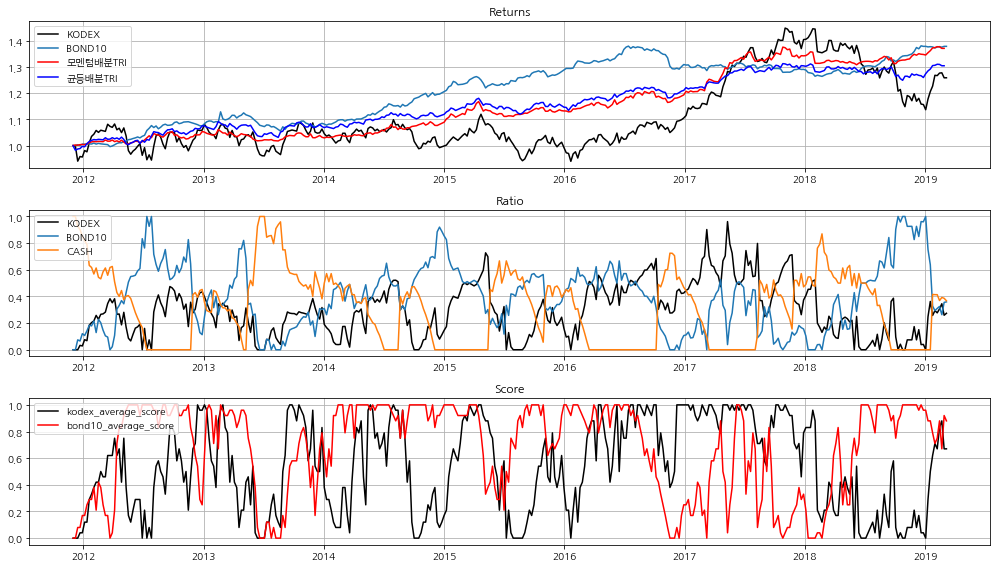

In [12]:
import matplotlib.pyplot as plt
#한글폰트사용하기
from matplotlib import rc, font_manager
import matplotlib
rc("font", family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.set_title("Returns")
ax1.plot(KODEX,color="Black",label="KODEX")
ax1.plot(BOND10,label="BOND10")
#ax1.plot(BOND3,label="CASH")
ax1.plot(모멘텀배분TRI,color="Red",label="모멘텀배분TRI")
ax1.plot(균등배분TRI,color="Blue",label="균등배분TRI")
ax1.grid()
ax1.legend(loc=2)

ax2.set_title("Ratio")
ax2.plot(kodex_ratio,color="Black", label="KODEX")
ax2.plot(bond10_ratio, label="BOND10")
ax2.plot(cash_ratio, label="CASH")
ax2.grid()
ax2.legend(loc=2)

ax3.set_title("Score")
ax3.plot(kodex_average_score, color="Black", label="kodex_average_score")
ax3.plot(bond10_average_score, color="Red", label="bond10_average_score")
ax3.grid()
ax3.legend(loc=2)

# 차트끼리 충돌을 방지합니다.
plt.tight_layout()
plt.show()